In [ ]:
!pip install git+https://github.com/qubvel/segmentation_models.pytorch

In [2]:
train_imgs_path = './data/train/images'
train_anns_path = './data/train/annotations.json'

val_imgs_path = './data/val/images'
val_anns_path = './data/val/annotations.json'

test_imgs_path = './data/test/images/'

In [3]:
def getCOCO(anns_path):
    
    # Initialise the COCO api object
    coco = COCO(anns_path)
    
    # Load the categories
    catIDs = coco.getCatIds()
    cats = coco.loadCats(catIDs)
    
    # Print the number of categories
    nms = [cat['name'] for cat in cats]
    
    # Create a dataframe of the count of each category
    df = pd.DataFrame(columns=['Category', 'ID', 'Count'])
    
    # Add each category and its count row by row
    for i, catID in enumerate(catIDs):
        imgIds = coco.getImgIds(catIds=catID)
        df.loc[i] = [nms[i]] + [catID] + [len(imgIds)]
    
    return coco, df

In [4]:
from pycocotools.coco import COCO
import os
import random
import cv2
import numpy as np
import pandas as pd
import imgaug.augmenters as iaa
import matplotlib.pyplot as plt

In [5]:
train_coco, train_classes = getCOCO(train_anns_path)
val_coco, val_classes = getCOCO(val_anns_path)

loading annotations into memory...
Done (t=6.24s)
creating index...
index created!
loading annotations into memory...
Done (t=0.07s)
creating index...
index created!


In [6]:
train_classes

,Category,ID,Count
0,beetroot-steamed-without-addition-of-salt,50,281
1,bread_wholemeal,101246,2030
2,jam,100546,1063
3,water,101129,4372
4,bread,101243,1287
...,...,...,...
318,sauce_curry,101274,71
319,watermelon_fresh,100031,129
320,white_asparagus,100113,90
321,cherries,100151,79


In [7]:
CLASSES = list(train_classes['Category'].values)

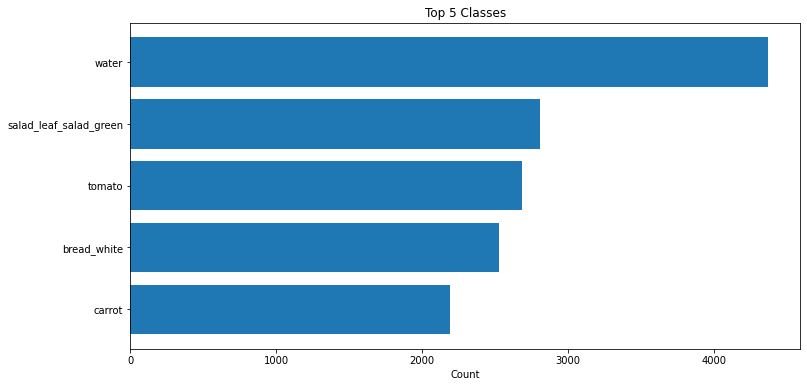

In [8]:
# Show the top 5 training classes by count
plt.figure(figsize=(12, 6))

top_5 = train_classes.sort_values(by=['Count'], ascending=False)[:5]
top_5_keys = list(top_5.Category)
top_5_values = list(top_5.Count)

top_5_keys.reverse()
top_5_values.reverse()
plt.barh(top_5_keys, top_5_values)
plt.title('Top 5 Classes')
plt.xlabel('Count')

plt.show()

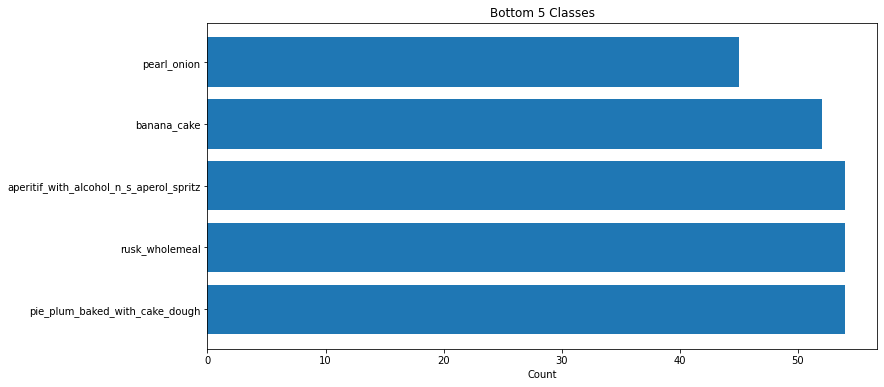

In [9]:
# Show the bottom 5 training classes by count
plt.figure(figsize=(12, 6))

bottom_5 = train_classes.sort_values(by=['Count'], ascending=True)[:5]
bottom_5_keys = list(bottom_5.Category)
bottom_5_values = list(bottom_5.Count)

bottom_5_keys.reverse()
bottom_5_values.reverse()
plt.barh(bottom_5_keys, bottom_5_values)
plt.title('Bottom 5 Classes')
plt.xlabel('Count')

plt.show()

In [10]:
import segmentation_models_pytorch as smp

In [11]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

In [196]:
class Dataset(BaseDataset):
    """FoodRecognition Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. normalization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['beetroot-steamed-without-addition-of-salt', 'bread_wholemeal', 'jam', 'water', 'bread', 
               'banana', 'soft_cheese', 'ham_raw', 'hard_cheese', 'cottage_cheese', 'coffee', 'fruit_mixed', 
               'pancake', 'tea', 'salmon_smoked', 'avocado', 'spring_onion_scallion', 'ristretto_with_caffeine', 
               'ham_n_s', 'egg', 'bacon', 'chips_french_fries', 'juice_apple', 'chicken', 'tomato', 'broccoli', 
               'shrimp_prawn', 'carrot', 'chickpeas', 'french_salad_dressing', 'pasta_hornli_ch', 'sauce_cream', 
               'pasta_n_s', 'tomato_sauce', 'cheese_n_s', 'pear', 'cashew_nut', 'almonds', 'lentil_n_s', 'mixed_vegetables', 
               'peanut_butter', 'apple', 'blueberries', 'cucumber', 'yogurt', 'butter', 'mayonnaise', 'soup', 'wine_red', 
               'wine_white', 'green_bean_steamed_without_addition_of_salt', 'sausage', 'pizza_margherita_baked', 'salami_ch',
               'mushroom', 'tart_n_s', 'rice', 'white_coffee', 'sunflower_seeds', 'bell_pepper_red_raw', 'zucchini', 
               'asparagus', 'tartar_sauce', 'lye_pretzel_soft', 'cucumber_pickled_ch', 'curry_vegetarian', 
               'soup_of_lentils_dahl_dhal', 'salmon', 'salt_cake_ch_vegetables_filled', 'orange', 'pasta_noodles', 
               'cream_double_cream_heavy_cream_45', 'cake_chocolate', 'pasta_spaghetti', 'black_olives', 'parmesan',
               'spaetzle', 'salad_lambs_ear', 'salad_leaf_salad_green', 'potato', 'white_cabbage', 'halloumi', 'beetroot_raw',
               'bread_grain', 'applesauce', 'cheese_for_raclette_ch', 'bread_white', 'curds_natural', 'quiche', 'beef_n_s',
               'taboule_prepared_with_couscous', 'aubergine_eggplant', 'mozzarella', 'pasta_penne', 
               'lasagne_vegetable_prepared', 'mandarine', 'kiwi', 'french_beans', 'spring_roll_fried',
               'caprese_salad_tomato_mozzarella', 'leaf_spinach', 'roll_of_half_white_or_white_flour_with_large_void',
               'omelette_with_flour_thick_crepe_plain', 'tuna', 'dark_chocolate', 'sauce_savoury_n_s', 'raisins_dried', 
               'ice_tea_on_black_tea_basis', 'kaki', 'smoothie', 'crepe_with_flour_plain', 'nuggets',
               'chili_con_carne_prepared', 'veggie_burger', 'chinese_cabbage', 'hamburger', 'soup_pumpkin', 'sushi',
               'chestnuts_ch', 'sauce_soya', 'balsamic_salad_dressing', 'pasta_twist', 'bolognaise_sauce', 'leek',
               'fajita_bread_only', 'potato_gnocchi', 'rice_noodles_vermicelli', 'bread_whole_wheat', 'onion', 'garlic',
               'hummus', 'pizza_with_vegetables_baked', 'beer', 'glucose_drink_50g', 'ratatouille', 'peanut', 'cauliflower',
               'green_olives', 'bread_pita', 'pasta_wholemeal', 'sauce_pesto', 'couscous', 'sauce', 'bread_toast',
               'water_with_lemon_juice', 'espresso', 'egg_scrambled', 'juice_orange', 'braided_white_loaf_ch',
               'emmental_cheese_ch', 'hazelnut_chocolate_spread_nutella_ovomaltine_caotina', 'tomme_ch', 'hazelnut', 'peach',
               'figs', 'mashed_potatoes_prepared_with_full_fat_milk_with_butter', 'pumpkin', 'swiss_chard', 'red_cabbage_raw',
               'spinach_raw', 'chicken_curry_cream_coconut_milk_curry_spices_paste', 'crunch_muesli', 'biscuit', 'meatloaf_ch',
               'fresh_cheese_n_s', 'honey', 'vegetable_mix_peas_and_carrots', 'parsley', 'brownie', 'ice_cream_n_s',
               'salad_dressing', 'dried_meat_n_s', 'chicken_breast', 'mixed_salad_chopped_without_sauce', 'feta',
               'praline_n_s', 'walnut', 'potato_salad', 'kolhrabi', 'alfa_sprouts', 'brussel_sprouts', 'gruyere_ch', 'bulgur',
               'grapes', 'chocolate_egg_small', 'cappuccino', 'crisp_bread', 'bread_black', 'rosti_n_s', 'mango',
               'muesli_dry', 'spinach', 'fish_n_s', 'risotto', 'crisps_ch', 'pork_n_s', 'pomegranate', 'sweet_corn', 'flakes',
               'greek_salad', 'sesame_seeds', 'bouillon', 'baked_potato', 'fennel', 'meat_n_s', 'croutons',
               'bell_pepper_red_stewed', 'nuts', 'breadcrumbs_unspiced', 'fondue', 'sauce_mushroom', 'strawberries',
               'pie_plum_baked_with_cake_dough', 'potatoes_au_gratin_dauphinois_prepared', 'capers', 'bread_wholemeal_toast',
               'red_radish', 'fruit_tart', 'beans_kidney', 'sauerkraut', 'mustard', 'country_fries', 'ketchup',
               'pasta_linguini_parpadelle_tagliatelle', 'chicken_cut_into_stripes_only_meat', 'cookies', 'sun_dried_tomatoe',
               'bread_ticino_ch', 'semi_hard_cheese', 'porridge_prepared_with_partially_skimmed_milk', 'juice',
               'chocolate_milk', 'bread_fruit', 'corn', 'dates', 'pistachio', 'cream_cheese_n_s', 'bread_rye',
               'witloof_chicory', 'goat_cheese_soft', 'grapefruit_pomelo', 'blue_mould_cheese', 'guacamole', 'tofu',
               'cordon_bleu', 'quinoa', 'kefir_drink', 'salad_rocket', 'pizza_with_ham_with_mushrooms_baked', 'fruit_coulis',
               'plums', 'pizza_with_ham_baked', 'pineapple', 'seeds_n_s', 'focaccia', 'mixed_milk_beverage',
               'coleslaw_chopped_without_sauce', 'sweet_potato', 'chicken_leg', 'croissant', 'cheesecake', 'sauce_cocktail',
               'croissant_with_chocolate_filling', 'pumpkin_seeds', 'artichoke', 'soft_drink_with_a_taste', 'apple_pie',
               'white_bread_with_butter_eggs_and_milk', 'savoury_pastry_stick', 'tuna_in_oil_drained', 'meat_terrine_pate',
               'falafel_balls', 'berries_n_s', 'latte_macchiato', 'sugar_melon_galia_honeydew_cantaloupe', 'mixed_seeds_n_s',
               'oil_vinegar_salad_dressing', 'celeriac', 'chocolate_mousse', 'lemon', 'chocolate_cookies',
               'birchermuesli_prepared_no_sugar_added', 'muffin', 'pine_nuts', 'french_pizza_from_alsace_baked',
               'chocolate_n_s', 'grits_polenta_maize_flour', 'wine_rose', 'cola_based_drink', 'raspberries',
               'roll_with_pieces_of_chocolate', 'cake_lemon', 'rice_wild', 'gluten_free_bread', 'pearl_onion', 'tzatziki',
               'ham_croissant_ch', 'corn_crisps', 'lentils_green_du_puy_du_berry', 'rice_whole_grain', 'cervelat_ch',
               'aperitif_with_alcohol_n_s_aperol_spritz', 'peas', 'tiramisu', 'apricots', 'lasagne_meat_prepared', 'brioche',
               'vegetable_au_gratin_baked', 'basil', 'butter_spread_puree_almond', 'pie_apricot', 'rusk_wholemeal',
               'pasta_in_conch_form', 'pasta_in_butterfly_form_farfalle', 'damson_plum', 'shoots_n_s', 'coconut',
               'banana_cake', 'sauce_curry', 'watermelon_fresh', 'white_asparagus', 'cherries', 'nectarine']
    
    def __init__(
            self, 
            images_dir, 
            coco,
            coco_classes,
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.coco = coco
        self.coco_classes = coco_classes
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image.copy(), (64,64), interpolation=cv2.INTER_AREA)
        image_size = image.shape[:2]
        
        mask = self.getMask(self.ids[i][:-4], image_size)
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)
    
    def getMask(self, image_id, image_size):
    
        # Create a zero array with the given size and number of classes
        mask = np.zeros((image_size[0], image_size[1], 324))

        annIds = self.coco.getAnnIds(int(image_id))
        anns = self.coco.loadAnns(annIds)

        for i, ann in enumerate(anns):
        
            # Get the binary mask for the annotation
            binary = cv2.resize(self.coco.annToMask(ann), (image_size[1], image_size[0]), interpolation=cv2.INTER_AREA)

            # Get the channel index for the annotation
            channel = self.coco_classes[self.coco_classes.ID == ann['category_id']].index[0] + 1

            # Update the channel of the annotation
            mask[:, :, channel] = binary
            
            # Update the background channel of the annotation
            if i == 0:
                mask[:, :, 0] = np.logical_or(mask[:, :, 0], np.logical_not(binary))
            else:
                mask[:, :, 0] = np.logical_and(mask[:, :, 0], np.logical_not(binary))

        return mask

In [13]:
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [14]:
import albumentations as albu

In [197]:
def get_training_augmentation():
    train_transform = [
        albu.HorizontalFlip(p=0.5),

        albu.IAAAdditiveGaussianNoise(p=0.2),
        albu.IAAPerspective(p=0.5),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightness(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.5,
        ),

        albu.OneOf(
            [
                albu.IAASharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.5,
        ),

        albu.OneOf(
            [
                albu.RandomContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.5,
        ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    test_transform = [
        #albu.augmentations.geometric.resize.Resize(320, 320)
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

/home/jovyan/.imgenv-berkut-1-gpu-0/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:261: FutureWarning: IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead
  warnings.warn("IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead", FutureWarning)
/home/jovyan/.imgenv-berkut-1-gpu-0/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:384: FutureWarning: This IAAPerspective is deprecated. Please use Perspective instead
  warnings.warn("This IAAPerspective is deprecated. Please use Perspective instead", FutureWarning)
/home/jovyan/.imgenv-berkut-1-gpu-0/lib/python3.7/site-packages/albumentations/augmentations/transforms.py:1151: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,
/home/jovyan/.imgenv-berkut-1-gpu-0/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:231: FutureWarning: IAASharpen is deprecated. Please use Sharpen instead
  warnings.warn("IAASharpen is dep

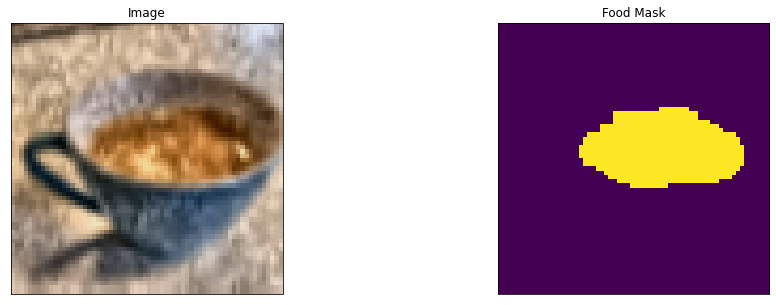

In [16]:
augmented_dataset = Dataset(images_dir=train_imgs_path, 
                            coco=train_coco, 
                            coco_classes=train_classes, 
                            classes=CLASSES,
                            augmentation=get_training_augmentation())

image, mask = augmented_dataset[4] # get some sample

for c in range(323):
    mask[:, :, c] = mask[:, :, c] * (c+1)
mask = np.max(mask, axis=2)
        
        
visualize(
    image=image, 
    food_mask=mask.squeeze(),
)


## Create model and train

In [204]:
ENCODER = 'resnet18'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = CLASSES
ACTIVATION = 'softmax2d' # could be None for logits or 'softmax2d' for multiclass segmentation
DEVICE = 'cuda'

# create segmentation model with pretrained encoder
model = smp.FPN(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES) + 1, 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [205]:
train_dataset = Dataset(
    images_dir=train_imgs_path, 
    coco=train_coco, 
    coco_classes=train_classes, 
    classes=CLASSES,
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
)

valid_dataset = Dataset(
    images_dir=val_imgs_path, 
    coco=val_coco, 
    coco_classes=val_classes, 
    classes=CLASSES,
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
)

train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True, num_workers=12)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=4)

In [206]:
import torch
import segmentation_models_pytorch.utils.metrics as smp_metrics
import segmentation_models_pytorch.utils.losses as smp_losses
import segmentation_models_pytorch.utils.train as smp_train

In [207]:
loss = smp_losses.DiceLoss()
metrics = [
    smp_metrics.IoU(threshold=0.5)
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=5e-4),
])

In [208]:
train_epoch = smp_train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp_train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [78]:
# for i in range(len(valid_dataset)):
#     try:
#         valid_dataset[i]
#     except:
#         print(i)

In [55]:
# ids = os.listdir(val_imgs_path)
# images_fps = [os.path.join(val_imgs_path, image_id) for image_id in ids]

In [56]:
# images_fps[580]

In [57]:
# images_fps[324]

In [58]:
# !rm {images_fps[580]}

In [59]:
# !rm {images_fps[324]}

In [209]:
max_score = 0

for i in range(0, 10):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './fpn_resnet.pth')
        print('Model saved!')
        
    if i == 3:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
valid: 100%|██████████| 946/946 [00:19<00:00, 48.43it/s, dice_loss - 0.3127, iou_score - 0.5465]
Model saved!

Epoch: 1
valid: 100%|██████████| 946/946 [00:19<00:00, 48.28it/s, dice_loss - 0.3127, iou_score - 0.5465]

Epoch: 2
train:  32%|███▏      | 34/107 [01:49<03:54,  3.21s/it, dice_loss - 0.3534, iou_score - 0.4779] 


KeyboardInterrupt: 

In [210]:
best_model = torch.load('fpn_resnet.pth')

# second model

In [215]:
ENCODER = 'efficientnet-b7'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = CLASSES
ACTIVATION = 'softmax2d' # could be None for logits or 'softmax2d' for multiclass segmentation
DEVICE = 'cuda'

# create segmentation model with pretrained encoder
model = smp.PSPNet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES) + 1, 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [229]:
ENCODER = 'efficientnet-b7'
CLASSES = CLASSES
ACTIVATION = 'softmax2d' # could be None for logits or 'softmax2d' for multiclass segmentation
DEVICE = 'cuda'

# create segmentation model with pretrained encoder
model = smp.PSPNet(
    encoder_name=ENCODER,  
    classes=len(CLASSES) + 1, 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER)

In [146]:
def get_training_augmentation_2():
    train_transform = [
        albu.HorizontalFlip(p=0.5),
    ]
    return albu.Compose(train_transform)

In [147]:
class Dataset2(BaseDataset):
    """FoodRecognition Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. normalization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['beetroot-steamed-without-addition-of-salt', 'bread_wholemeal', 'jam', 'water', 'bread', 
               'banana', 'soft_cheese', 'ham_raw', 'hard_cheese', 'cottage_cheese', 'coffee', 'fruit_mixed', 
               'pancake', 'tea', 'salmon_smoked', 'avocado', 'spring_onion_scallion', 'ristretto_with_caffeine', 
               'ham_n_s', 'egg', 'bacon', 'chips_french_fries', 'juice_apple', 'chicken', 'tomato', 'broccoli', 
               'shrimp_prawn', 'carrot', 'chickpeas', 'french_salad_dressing', 'pasta_hornli_ch', 'sauce_cream', 
               'pasta_n_s', 'tomato_sauce', 'cheese_n_s', 'pear', 'cashew_nut', 'almonds', 'lentil_n_s', 'mixed_vegetables', 
               'peanut_butter', 'apple', 'blueberries', 'cucumber', 'yogurt', 'butter', 'mayonnaise', 'soup', 'wine_red', 
               'wine_white', 'green_bean_steamed_without_addition_of_salt', 'sausage', 'pizza_margherita_baked', 'salami_ch',
               'mushroom', 'tart_n_s', 'rice', 'white_coffee', 'sunflower_seeds', 'bell_pepper_red_raw', 'zucchini', 
               'asparagus', 'tartar_sauce', 'lye_pretzel_soft', 'cucumber_pickled_ch', 'curry_vegetarian', 
               'soup_of_lentils_dahl_dhal', 'salmon', 'salt_cake_ch_vegetables_filled', 'orange', 'pasta_noodles', 
               'cream_double_cream_heavy_cream_45', 'cake_chocolate', 'pasta_spaghetti', 'black_olives', 'parmesan',
               'spaetzle', 'salad_lambs_ear', 'salad_leaf_salad_green', 'potato', 'white_cabbage', 'halloumi', 'beetroot_raw',
               'bread_grain', 'applesauce', 'cheese_for_raclette_ch', 'bread_white', 'curds_natural', 'quiche', 'beef_n_s',
               'taboule_prepared_with_couscous', 'aubergine_eggplant', 'mozzarella', 'pasta_penne', 
               'lasagne_vegetable_prepared', 'mandarine', 'kiwi', 'french_beans', 'spring_roll_fried',
               'caprese_salad_tomato_mozzarella', 'leaf_spinach', 'roll_of_half_white_or_white_flour_with_large_void',
               'omelette_with_flour_thick_crepe_plain', 'tuna', 'dark_chocolate', 'sauce_savoury_n_s', 'raisins_dried', 
               'ice_tea_on_black_tea_basis', 'kaki', 'smoothie', 'crepe_with_flour_plain', 'nuggets',
               'chili_con_carne_prepared', 'veggie_burger', 'chinese_cabbage', 'hamburger', 'soup_pumpkin', 'sushi',
               'chestnuts_ch', 'sauce_soya', 'balsamic_salad_dressing', 'pasta_twist', 'bolognaise_sauce', 'leek',
               'fajita_bread_only', 'potato_gnocchi', 'rice_noodles_vermicelli', 'bread_whole_wheat', 'onion', 'garlic',
               'hummus', 'pizza_with_vegetables_baked', 'beer', 'glucose_drink_50g', 'ratatouille', 'peanut', 'cauliflower',
               'green_olives', 'bread_pita', 'pasta_wholemeal', 'sauce_pesto', 'couscous', 'sauce', 'bread_toast',
               'water_with_lemon_juice', 'espresso', 'egg_scrambled', 'juice_orange', 'braided_white_loaf_ch',
               'emmental_cheese_ch', 'hazelnut_chocolate_spread_nutella_ovomaltine_caotina', 'tomme_ch', 'hazelnut', 'peach',
               'figs', 'mashed_potatoes_prepared_with_full_fat_milk_with_butter', 'pumpkin', 'swiss_chard', 'red_cabbage_raw',
               'spinach_raw', 'chicken_curry_cream_coconut_milk_curry_spices_paste', 'crunch_muesli', 'biscuit', 'meatloaf_ch',
               'fresh_cheese_n_s', 'honey', 'vegetable_mix_peas_and_carrots', 'parsley', 'brownie', 'ice_cream_n_s',
               'salad_dressing', 'dried_meat_n_s', 'chicken_breast', 'mixed_salad_chopped_without_sauce', 'feta',
               'praline_n_s', 'walnut', 'potato_salad', 'kolhrabi', 'alfa_sprouts', 'brussel_sprouts', 'gruyere_ch', 'bulgur',
               'grapes', 'chocolate_egg_small', 'cappuccino', 'crisp_bread', 'bread_black', 'rosti_n_s', 'mango',
               'muesli_dry', 'spinach', 'fish_n_s', 'risotto', 'crisps_ch', 'pork_n_s', 'pomegranate', 'sweet_corn', 'flakes',
               'greek_salad', 'sesame_seeds', 'bouillon', 'baked_potato', 'fennel', 'meat_n_s', 'croutons',
               'bell_pepper_red_stewed', 'nuts', 'breadcrumbs_unspiced', 'fondue', 'sauce_mushroom', 'strawberries',
               'pie_plum_baked_with_cake_dough', 'potatoes_au_gratin_dauphinois_prepared', 'capers', 'bread_wholemeal_toast',
               'red_radish', 'fruit_tart', 'beans_kidney', 'sauerkraut', 'mustard', 'country_fries', 'ketchup',
               'pasta_linguini_parpadelle_tagliatelle', 'chicken_cut_into_stripes_only_meat', 'cookies', 'sun_dried_tomatoe',
               'bread_ticino_ch', 'semi_hard_cheese', 'porridge_prepared_with_partially_skimmed_milk', 'juice',
               'chocolate_milk', 'bread_fruit', 'corn', 'dates', 'pistachio', 'cream_cheese_n_s', 'bread_rye',
               'witloof_chicory', 'goat_cheese_soft', 'grapefruit_pomelo', 'blue_mould_cheese', 'guacamole', 'tofu',
               'cordon_bleu', 'quinoa', 'kefir_drink', 'salad_rocket', 'pizza_with_ham_with_mushrooms_baked', 'fruit_coulis',
               'plums', 'pizza_with_ham_baked', 'pineapple', 'seeds_n_s', 'focaccia', 'mixed_milk_beverage',
               'coleslaw_chopped_without_sauce', 'sweet_potato', 'chicken_leg', 'croissant', 'cheesecake', 'sauce_cocktail',
               'croissant_with_chocolate_filling', 'pumpkin_seeds', 'artichoke', 'soft_drink_with_a_taste', 'apple_pie',
               'white_bread_with_butter_eggs_and_milk', 'savoury_pastry_stick', 'tuna_in_oil_drained', 'meat_terrine_pate',
               'falafel_balls', 'berries_n_s', 'latte_macchiato', 'sugar_melon_galia_honeydew_cantaloupe', 'mixed_seeds_n_s',
               'oil_vinegar_salad_dressing', 'celeriac', 'chocolate_mousse', 'lemon', 'chocolate_cookies',
               'birchermuesli_prepared_no_sugar_added', 'muffin', 'pine_nuts', 'french_pizza_from_alsace_baked',
               'chocolate_n_s', 'grits_polenta_maize_flour', 'wine_rose', 'cola_based_drink', 'raspberries',
               'roll_with_pieces_of_chocolate', 'cake_lemon', 'rice_wild', 'gluten_free_bread', 'pearl_onion', 'tzatziki',
               'ham_croissant_ch', 'corn_crisps', 'lentils_green_du_puy_du_berry', 'rice_whole_grain', 'cervelat_ch',
               'aperitif_with_alcohol_n_s_aperol_spritz', 'peas', 'tiramisu', 'apricots', 'lasagne_meat_prepared', 'brioche',
               'vegetable_au_gratin_baked', 'basil', 'butter_spread_puree_almond', 'pie_apricot', 'rusk_wholemeal',
               'pasta_in_conch_form', 'pasta_in_butterfly_form_farfalle', 'damson_plum', 'shoots_n_s', 'coconut',
               'banana_cake', 'sauce_curry', 'watermelon_fresh', 'white_asparagus', 'cherries', 'nectarine']
    
    def __init__(
            self, 
            images_dir, 
            coco,
            coco_classes,
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.coco = coco
        self.coco_classes = coco_classes
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image.copy(), (48,48), interpolation=cv2.INTER_AREA)
        image_size = image.shape[:2]
        
        mask = self.getMask(self.ids[i][:-4], image_size)
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)
    
    def getMask(self, image_id, image_size):
    
        # Create a zero array with the given size and number of classes
        mask = np.zeros((image_size[0], image_size[1], 323 + 1))

        annIds = self.coco.getAnnIds(int(image_id))
        anns = self.coco.loadAnns(annIds)

        for i, ann in enumerate(anns):
        
            # Get the binary mask for the annotation
            binary = cv2.resize(self.coco.annToMask(ann), (image_size[1], image_size[0]), interpolation=cv2.INTER_AREA)

            # Get the channel index for the annotation
            channel = self.coco_classes[self.coco_classes.ID == ann['category_id']].index[0] + 1

            # Update the channel of the annotation
            mask[:, :, channel] = binary
            
            # Update the background channel of the annotation
            if i == 0:
                mask[:, :, 0] = np.logical_or(mask[:, :, 0], np.logical_not(binary))
            else:
                mask[:, :, 0] = np.logical_and(mask[:, :, 0], np.logical_not(binary))

        return mask

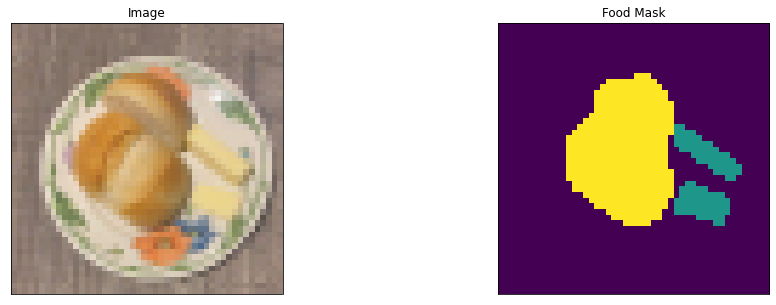

In [148]:
augmented_dataset = Dataset2(images_dir=train_imgs_path, 
                            coco=train_coco, 
                            coco_classes=train_classes, 
                            classes=CLASSES,
                            augmentation=get_training_augmentation_2())

image, mask = augmented_dataset[5] # get some sample

for c in range(324):
    mask[:, :, c] = mask[:, :, c] * (c+1)
mask = np.max(mask, axis=2)
        
        
visualize(
    image=image, 
    food_mask=mask.squeeze(),
)


In [230]:
train_dataset = Dataset2(
    images_dir=train_imgs_path, 
    coco=train_coco, 
    coco_classes=train_classes, 
    classes=CLASSES,
    augmentation=get_training_augmentation_2(),
    preprocessing=get_preprocessing(preprocessing_fn),
)

valid_dataset = Dataset2(
    images_dir=val_imgs_path, 
    coco=val_coco, 
    coco_classes=val_classes, 
    classes=CLASSES,
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=12)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=4)

In [231]:
loss = smp_losses.DiceLoss()
metrics = [
    smp_metrics.IoU(threshold=0.5),
    smp_metrics.Precision(),
    smp_metrics.Recall()
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=1e-4),
])

In [232]:
train_epoch = smp_train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp_train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [152]:
max_score = 0

for i in range(0, 10):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './PSP_Effnet.pth')
        print('Model saved!')
    
    if i == 3:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
valid: 100%|██████████| 946/946 [00:31<00:00, 30.48it/s, dice_loss - 0.3132, iou_score - 0.5468, precision - 0.6955, recall - 0.681] 
Model saved!

Epoch: 1
valid: 100%|██████████| 946/946 [00:31<00:00, 30.05it/s, dice_loss - 0.3127, iou_score - 0.5468, precision - 0.6955, recall - 0.681] 

Epoch: 2
valid: 100%|██████████| 946/946 [00:31<00:00, 30.31it/s, dice_loss - 0.3126, iou_score - 0.5468, precision - 0.6955, recall - 0.681] 

Epoch: 3
valid: 100%|██████████| 946/946 [00:31<00:00, 30.18it/s, dice_loss - 0.3125, iou_score - 0.5468, precision - 0.6955, recall - 0.681] 
Decrease decoder learning rate to 1e-5!

Epoch: 4
valid: 100%|██████████| 946/946 [00:30<00:00, 30.70it/s, dice_loss - 0.3125, iou_score - 0.5468, precision - 0.6955, recall - 0.681] 

Epoch: 5
valid: 100%|██████████| 946/946 [00:31<00:00, 30.44it/s, dice_loss - 0.3125, iou_score - 0.5468, precision - 0.6955, recall - 0.681] 

Epoch: 6
valid: 100%|██████████| 946/946 [00:31<00:00, 30.09it/s, dice_loss - 0.31

In [233]:
max_score = 0

for i in range(0, 10):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './PSP_Effnet2.pth')
        print('Model saved!')
    
    if i == 3:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
valid: 100%|██████████| 946/946 [00:31<00:00, 30.05it/s, dice_loss - 0.3132, iou_score - 0.5468, precision - 0.6955, recall - 0.681] 
Model saved!

Epoch: 1
valid: 100%|██████████| 946/946 [00:31<00:00, 29.67it/s, dice_loss - 0.3127, iou_score - 0.5468, precision - 0.6955, recall - 0.681] 

Epoch: 2
train:   0%|          | 0/213 [00:00<?, ?it/s]

Exception ignored in: <function _releaseLock at 0x7f51c50d5050>
Traceback (most recent call last):
  File "/home/user/conda/lib/python3.7/logging/__init__.py", line 221, in _releaseLock
    def _releaseLock():
KeyboardInterrupt


train:   0%|          | 0/213 [00:12<?, ?it/s]


RuntimeError: DataLoader worker (pid(s) 1389134, 1389390, 1389646, 1389902, 1390158, 1390414, 1390670, 1390926, 1391182, 1391438, 1391694) exited unexpectedly